In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import optuna
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_parquet('/kaggle/input/haca-data/train_main.parquet')
temp = pd.read_parquet("/kaggle/input/haca-data/train_card_spending.parquet")
target = pd.read_csv('/kaggle/input/haca-data/train_target.csv')
data = data.merge(temp, on="user_id", how='left')
data = data.merge(target, on='user_id', how='left')
# data.target = np.log1p(data.target)

In [4]:
data.shape

(213345, 911)

In [5]:
target.shape

(213345, 2)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='target', ylabel='Count'>

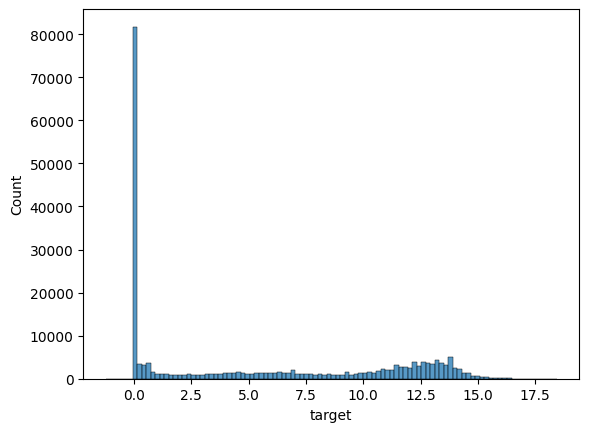

In [10]:
sns.histplot(np.log1p(target.target), bins=100)

In [6]:
log_target = np.log1p(target.target)

In [7]:
log_target.shape

(213345,)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


target
0.000000     76863
0.009950      1087
0.019803       573
0.029559       440
0.039221       361
             ...  
13.246289        1
7.842122         1
9.112222         1
14.027031        1
13.507674        1
Name: count, Length: 100154, dtype: int64

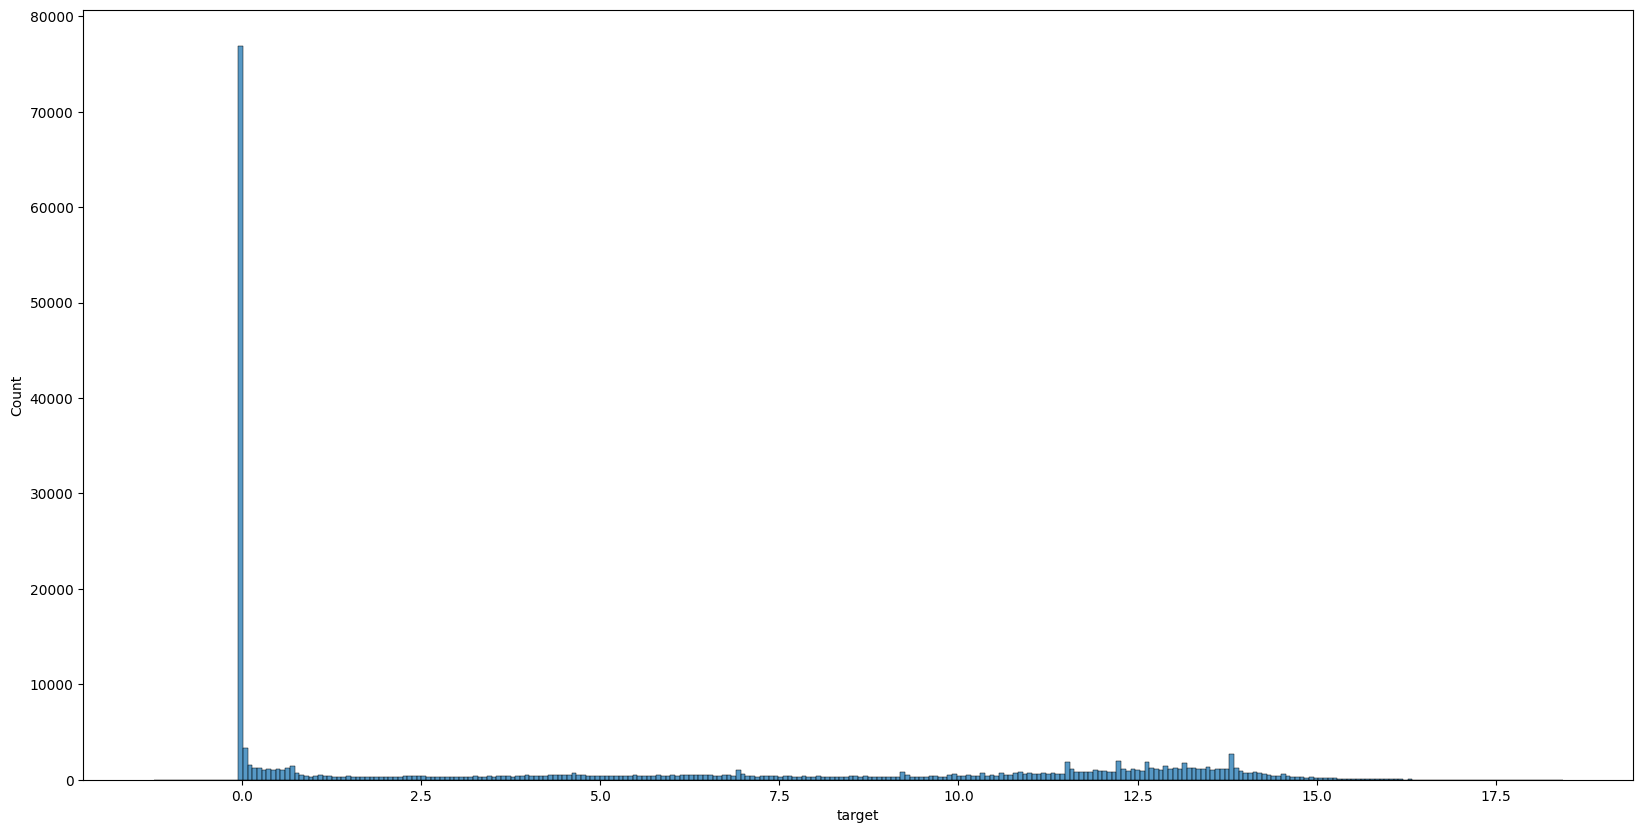

In [28]:
plt.figure(figsize=(20,10))
sns.histplot(log_target, bins=300)
log_target.value_counts()

In [37]:
log_target = pd.DataFrame(log_target)

Различия в e^x x -> 0 не повлияют на ошибку, зато позволит регрессору сконцентрироваться на значениях более отдаленных от 0

In [53]:
log_target[log_target < 1] = 0

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

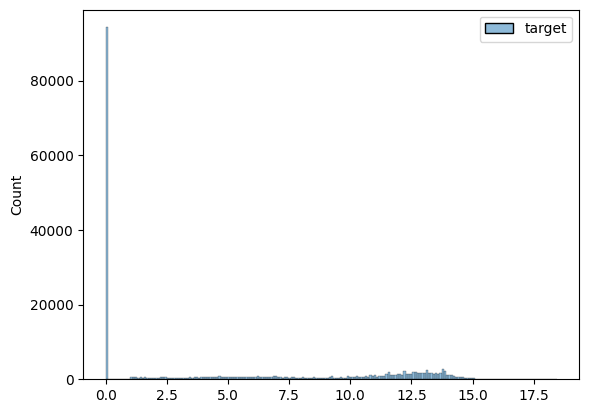

In [54]:
sns.histplot(log_target, bins=200)

In [57]:
pd.set_option('display.min_rows', 20)
print(log_target.value_counts())

target   
0.000000     94265
13.815512      230
11.512935      130
12.206078      116
13.122365      114
9.210440        95
6.908755        90
12.611541       85
10.819798       74
12.899222       67
             ...  
10.037168        1
10.037007        1
10.036140        1
10.035952        1
10.035936        1
10.035435        1
10.034965        1
10.034223        1
10.034204        1
10.037986        1
Name: count, Length: 99982, dtype: int64


In [8]:
new_data = data.loc[:,data.isna().mean() <= 0.7]
len(new_data.columns)

658

In [9]:
new_data.shape

(213345, 658)

In [59]:
new_data.isna().mean().sort_values(ascending=False)

sum_tr_alkochol_12m                     0.697734
sum_tr_construction_services_6          0.695939
sum_tr_internet_1                       0.695362
sum_tr_repair_6m                        0.694401
sum_tr_medical_health_services_12       0.693698
sum_tr_transportation_other_6           0.691054
avg_dep_avg_balance_3month_amt_term     0.689597
max_dep_avg_balance_12month_amt_term    0.689597
max_max_dep_balance_amt_term            0.689597
max_dep_avg_balance_3month_amt_term     0.689597
                                          ...   
savings_sum_sa_2m                       0.000000
savings_sum_bro_credit_9m               0.000000
savings_sum_dep_topup_12m               0.000000
savings_sum_dep_withdrawal_1m           0.000000
savings_sum_dep_withdrawal_3m           0.000000
savings_sum_dep_withdrawal_6m           0.000000
savings_sum_dep_withdrawal_12m          0.000000
savings_sum_sa_now                      0.000000
savings_sum_sa_1m                       0.000000
savings_sum_bro_cred

# Bin Classification

In [10]:
X = new_data.drop(columns=['target'])
cat_features = list(X.select_dtypes('object').columns)
X[cat_features] = X[cat_features].fillna('NaN')
y = log_target
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.5, random_state=42)

In [11]:
y.shape

(213345,)

In [12]:
X.shape

(213345, 657)

In [13]:
y_train_clf = (y_train != 0).astype('int')
# y_train_clf.value_counts()
y_val_clf = (y_val != 0).astype('int')

In [16]:
class_not_zero_counts = y_train_clf.value_counts().loc[1]
class_is_zero_counts = y_train_clf.value_counts().loc[0]

In [19]:
class_not_zero_counts = y_train_clf.value_counts().loc[1]
class_is_zero_counts = y_train_clf.value_counts().loc[0]
total_counts = 68279 + 38393
weight_0 = (total_counts - class_is_zero_counts) / total_counts
weight_1 = (total_counts - class_not_zero_counts) / total_counts

In [20]:
weight_0, weight_1

(0.6400836208189591, 0.35991637918104097)

In [21]:
class_weights = {0: weight_0, 1: weight_1}
class_weights

{0: 0.6400836208189591, 1: 0.35991637918104097}

In [22]:

model = CatBoostClassifier(iterations=100, 
                           learning_rate=0.15, 
                           depth=2, 
                           verbose=200,
                           class_weights=class_weights,
                           eval_metric='AUC', 
                           random_state=42,
                          task_type = 'GPU')
train_pool = Pool(X_train, label=y_train_clf, cat_features=cat_features)
model.fit(train_pool)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 142ms	remaining: 14.1s
99:	total: 1.14s	remaining: 0us


In [23]:
predicts_clf_proba = model.predict_proba(X_val)[:,1]
predict_clf = model.predict(X_val)
pd.Series(predict_clf).value_counts()

1    69354
0    37319
Name: count, dtype: int64

In [24]:
f'F1:{f1_score(y_val_clf, predict_clf)}, RocAuc:{roc_auc_score(y_val_clf,predicts_clf_proba)}'

'F1:0.9416750874183065, RocAuc:0.9785195006904208'

In [26]:
clf = model
clf.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 100,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalizati

In [27]:
feature_importances = clf.get_feature_importance()  # Получаем важность признаков
feature_names = X_train.columns  # Получаем имена признаков

# Создаем DataFrame для удобного отображения
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортируем по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим результат
print(importance_df)

                                              Feature  Importance
22   avg_dep_avg_balance_fact_1month_amt_term_savings   80.451901
106            sum_dep_income_1month_amt_term_savings    4.071396
204                                 savings_avg_sa_1m    2.824692
98            sum_dep_expense_1month_amt_term_savings    2.687148
82               min_max_dep_balance_amt_term_savings    2.417656
..                                                ...         ...
248                                savings_avg_oms_1m    0.000000
249                                savings_avg_oms_3m    0.000000
250                                savings_avg_oms_6m    0.000000
251                                savings_avg_oms_9m    0.000000
242                                savings_sum_oms_1m    0.000000

[657 rows x 2 columns]


# Regression fit

In [28]:
data_for_reg = new_data[np.log1p(new_data.target) >= 1]

In [29]:
len(data_for_reg)

119080

In [139]:
sum(data_for_reg.target == 0)

0

In [30]:
X = data_for_reg.drop("target", axis = 1)
X[cat_features] = X[cat_features].fillna('NaN')
y = np.log1p(data_for_reg.target)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.4,random_state=42)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='target', ylabel='Count'>

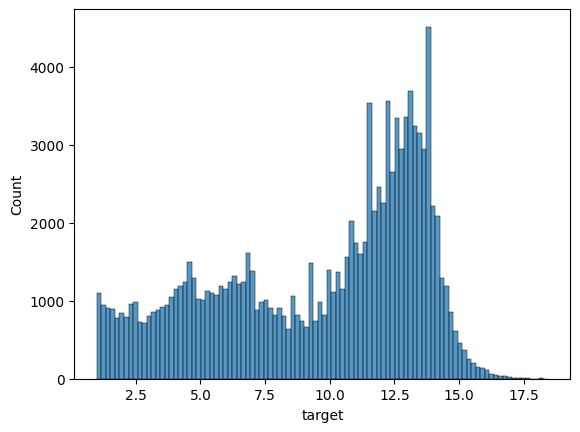

In [31]:

sns.histplot(y, bins=100)

In [33]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'depth': trial.suggest_int('depth', 2, 8),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1), 
        'random_strength': trial.suggest_float('random_strength', 0, 100),       
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),  
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Инициализация модели
    model = CatBoostRegressor(**param, task_type='GPU', verbose=0, cat_features=cat_features)

    # Обучение модели на логарифмированных данных
    model.fit(X_train, y_train)

    # Предсказания на валидационной выборке
    y_pred_log = model.predict(X_val)

    # Вычисление RMSLE
    rmsle_value = np.sqrt(mean_squared_error(y_val, y_pred_log))  # Преобразуем предсказания обратно
    return rmsle_value

In [34]:
study = optuna.create_study(direction='minimize')  # минимизируем RMSLE
study.optimize(objective, n_trials=20)

# Результаты
print('Best hyperparameters:', study.best_params)
print('Best RMSLE:', study.best_value)

[I 2025-03-16 11:05:28,579] A new study created in memory with name: no-name-0a66f2f9-9690-4f0c-966b-be889eb624b8
<ipython-input-33-4457bf913350>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-33-4457bf913350>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e1),
[I 2025-03-16 11:05:32,212] Trial 0 finished with value: 1.316677765451577 and parameters: {'iterations': 151, 'learning_rate': 0.06502262765385118, 'depth': 3, 'l2_leaf_reg': 0.854732517209321, 'border_count': 147, 'bagging_temperature': 0.9817050758180121, 'ran

Best hyperparameters: {'iterations': 938, 'learning_rate': 0.015425806761094748, 'depth': 7, 'l2_leaf_reg': 0.00013521436632377382, 'border_count': 225, 'bagging_temperature': 0.5341959976190552, 'random_strength': 23.527679328459143, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 22}
Best RMSLE: 1.0400475048327382


In [35]:
param = {'iterations': 938, 'learning_rate': 0.015425806761094748, 'depth': 7, 'l2_leaf_reg': 0.00013521436632377382, 'border_count': 225, 'bagging_temperature': 0.5341959976190552, 'random_strength': 23.527679328459143, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 22}
model_for_reg = CatBoostRegressor(**param, task_type='GPU', verbose=0, cat_features=cat_features)

In [36]:
model_for_reg.fit(X_train,y_train)

In [69]:
model_for_reg.fit(X_train, y_train)

In [85]:
X = data_for_reg.drop("target", axis = 1)
X[cat_features] = X[cat_features].fillna('NaN')
y = data_for_reg.target
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3,random_state=42)

In [38]:
preds = model_for_reg.predict(X_val)
preds = np.exp(preds)-1
preds

array([4.68682547e+05, 3.61225093e+05, 7.64172147e+02, ...,
       2.62302408e+02, 1.49766218e+01, 2.43274941e+01])

In [39]:
y_val = np.exp(y_val)-1

In [40]:
np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(preds)))

1.0401158348561672

# Pipeline
1. Классификатор предсказывает значения для таргета 0 или не ноль
2. там где не ноль, предсказывает регрессия
3. сабмит собираем

In [55]:
test = pd.read_parquet("/kaggle/input/haca-data/test_main.parquet")
temp_test = pd.read_parquet("/kaggle/input/haca-data/test_card_spending.parquet")
test = test.merge(temp_test, how="left", on="user_id")
user_id = test.user_id
test[cat_features] = test[cat_features].fillna('NaN')

In [56]:
features = list(new_data.drop("target", axis=1).columns)
test = test[features]


In [58]:
total_predicts = pd.Series(model.predict(test))
len(total_predicts)

318451

In [59]:
total_predicts[total_predicts == 1] = model_for_reg.predict(test[total_predicts == 1])

<ipython-input-59-c5a0e9d50d00>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[13.69076401  2.60897677  2.6250867  ...  1.08974052  9.33810674
  0.90293033]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  total_predicts[total_predicts == 1] = model_for_reg.predict(test[total_predicts == 1])


In [60]:
total_predicts

0         13.690764
1          0.000000
2          2.608977
3          0.000000
4          2.625087
            ...    
318446    12.884385
318447     1.089741
318448     9.338107
318449     0.902930
318450     0.000000
Length: 318451, dtype: float64

In [61]:
total_predicts[total_predicts != 0] = (np.exp(total_predicts[total_predicts != 0]) - 1)

In [62]:
total_predicts

0         882719.601588
1              0.000000
2             12.585143
3              0.000000
4             12.805771
              ...      
318446    394109.017721
318447         1.973502
318448     11361.874981
318449         1.466821
318450         0.000000
Length: 318451, dtype: float64

In [63]:
try7 = pd.DataFrame()
try7["user_id"] = user_id
try7["predict"] = total_predicts

In [64]:
try7

,user_id,predict
0,1000008,882719.601588
1,1000009,0.000000
2,1000013,12.585143
3,1000016,0.000000
4,1000017,12.805771
...,...,...
318446,2499983,394109.017721
318447,2499984,1.973502
318448,2499989,11361.874981
318449,2499991,1.466821


In [65]:
try7.to_csv('try7.csv')

In [66]:
len(try7)

318451

In [65]:
preds = model_for_reg.predict(test)

In [67]:
preds = np.exp(preds)-1

In [68]:
preds

array([6.6660046 , 5.90633536, 6.14502994, ..., 6.4958277 , 5.87979819,
       6.1032643 ])

In [74]:
preds = clf.predict(test)

In [75]:
preds

array([1, 0, 1, ..., 1, 1, 0])